In [1]:
## import libraries
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import json
import pickle
import os

In [2]:
#set up data
#please note that you need to download the data and keep it in the same directory to train our neural network
#you can download the data here: https://www.kaggle.com/code/scarfsman/german-used-cars-data-cleaning-eda/output
df = pd.read_csv('clean_data.csv', encoding="ISO-8859-1")

In [3]:
#this will sort the cars by brand and therefore all models from a similar brand
#will have similar results
df = df.sort_values(by='model')

In [4]:
#encode models with an integer label
#this approach has the large drawback which is that the model will think that the label which is an integer
#will have a relationship between values. This is not true, but by sorting by model, we will at least have some semblence
#of value between consecutive cars
#I also make a key so that we can convert car names into their labels
df['encoded_model'] = df['model'].astype('category').cat.codes
model_key = df[['model', 'encoded_model']].drop_duplicates().set_index('encoded_model')

df['encoded_transmission'] = df['transmission_type'].astype('category').cat.codes
transmission_key = df[['transmission_type', 'encoded_transmission']].drop_duplicates().set_index('encoded_transmission')

df['encoded_fuel'] = df['fuel_type'].astype('category').cat.codes
fuel_key = df[['fuel_type', 'encoded_fuel']].drop_duplicates().set_index('encoded_fuel')


In [5]:
#save all keys
model_key_dict = model_key['model'].to_dict()

# Save the model key as a JSON file
with open('model_key.json', 'w') as file:
    json.dump(model_key_dict, file)

transmission_key_dict = transmission_key['transmission_type'].to_dict()

# Save the model key as a JSON file
with open('transmission_key.json', 'w') as file:
    json.dump(transmission_key_dict, file)

fuel_key_dict = fuel_key['fuel_type'].to_dict()

# Save the model key as a JSON file
with open('fuel_key.json', 'w') as file:
    json.dump(fuel_key_dict, file)



In [7]:
#drop data that we are not working with
df = df.drop(columns = ['Unnamed: 0', 'brand', 'registration_date', 'power_ps', 'fuel_consumption_g_km', 'offer_description', 'model', 'color', 'fuel_consumption_l_100km', 'transmission_type', 'fuel_type', 'power_kw'], axis = 1)

In [9]:
#scale columns from 0 to 1
columns_to_scale = ['year', 'mileage_in_km']

scaler = MinMaxScaler()
scaler.fit(df[columns_to_scale])
df[columns_to_scale] = scaler.transform(df[columns_to_scale])

#save scaler data for use in user file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [10]:
#view data
df

,year,price_in_euro,mileage_in_km,encoded_model,encoded_transmission,encoded_fuel
272,0.500000,5490,0.032932,0,1,8
133,0.357143,1490,0.061974,0,1,8
152,0.392857,2980,0.074749,0,1,1
1251,1.000000,48340,0.000013,0,0,8
1007,0.964286,39900,0.004868,0,0,8
...,...,...,...,...,...,...
181995,0.321429,5850,0.021316,1247,2,8
181989,0.285714,7999,0.032263,1247,0,8
181988,0.285714,4300,0.040734,1247,1,8
182008,0.357143,10399,0.022500,1247,0,8


In [11]:
df.dtypes

year                    float64
price_in_euro             int64
mileage_in_km           float64
encoded_model             int16
encoded_transmission       int8
encoded_fuel               int8
dtype: object

In [12]:
#set device for PyTorch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
#create X tensor for input data and Y tensor for prices
Y = torch.tensor(df.price_in_euro)

columns_to_concat = df.drop(columns = "price_in_euro", axis = 1).columns
column_values = []

column_values = [torch.reshape(torch.tensor(df[column].values), (len(df),1)) for column in columns_to_concat]
X = torch.cat([values for values in column_values], dim = 1)

In [14]:
print(Y.shape)
print(X.size())

torch.Size([224991])


torch.Size([224991, 5])

In [15]:
#train test split
test_percent = 0.05
seed = 69420

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_percent, random_state = seed)

In [16]:
#create train and test dataloaders
b = 512

Y_train, Y_test = Y_train.type(torch.float32).to(device), Y_test.type(torch.float32).to(device)
X_train, X_test = X_train.to(device).type(torch.float32), X_test.to(device).type(torch.float32)

train_data = torch.utils.data.TensorDataset(X_train, Y_train)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size = b,
                                               shuffle = True)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size = b,
                                              shuffle = False)

In [18]:
#create model class
D = X_train.size(1)
K = 1
nodes = 2 ** 8


class carlearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Sequential(nn.Linear(D, nodes), 
                                   nn.ReLU())
        self.mid1 = nn.Sequential(nn.Linear(nodes, nodes), 
                                 nn.ReLU(),
                                nn.Linear(nodes, nodes), 
                                 nn.ReLU())
        self.mid2 = nn.Sequential(nn.Linear(nodes, nodes), 
                                  nn.ReLU(),
                                nn.Linear(nodes, nodes), 
                                 nn.ReLU())
        self.output = nn.Linear(nodes, K)
    
    def forward(self, x):
        
        return self.output(self.mid2(self.mid1(self.input(x)))).squeeze(-1)

In [19]:
#instance of class
model = carlearner().to(device)

In [20]:
#load previous model data if there is any
if os.path.exists('label_normal.pth'):
        print("Loading previous model")
        model.load_state_dict(torch.load('label_normal.pth'))

Loading previous model


In [21]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        
        y_pred = model(X)
        # print(y.shape)
        loss = loss_fn(y_pred, y)
        #print(y_pred.shape)
        #print(loss)
        train_loss += loss.item()
        
        optim.zero_grad()
        
        loss.backward()
        
        optim.step()
        
        #if batch * b % 4000 == 0:
         #   print(f"for the {b * batch}th data entry, cumulative loss is {train_loss/(batch+1)}, {epoch}")


def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               epoch, 
               device: torch.device = device):
    test_loss = 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
    
    test_loss /= len(data_loader)
    print(f"test loss = {test_loss}", 'epoch is', epoch)
    return test_loss

In [22]:
#train model
epochs = 20
rate = .00000001

loss = nn.L1Loss()
optim = torch.optim.Adam(params = model.parameters(), lr = rate)
array = np.zeros(epochs)

for epoch in range(epochs):
    train_step(model = model,
               data_loader = train_dataloader,
               loss_fn = loss,
               optim = optim)
    
    array[epoch] = test_step(model = model,
              data_loader = test_dataloader,
              loss_fn = loss, epoch = epoch)

test loss = 5760.024147727273 epoch is 0
test loss = 5759.790838068182 epoch is 1
test loss = 5759.649658203125 epoch is 2
test loss = 5759.569358132102 epoch is 3
test loss = 5759.484064275568 epoch is 4
test loss = 5759.423939098011 epoch is 5
test loss = 5759.362815163352 epoch is 6
test loss = 5759.336558948864 epoch is 7
test loss = 5759.376686789773 epoch is 8
test loss = 5759.397416548295 epoch is 9
test loss = 5759.421630859375 epoch is 10
test loss = 5759.475763494318 epoch is 11
test loss = 5759.493386008523 epoch is 12
test loss = 5759.453280362216 epoch is 13
test loss = 5759.492986505682 epoch is 14
test loss = 5759.560546875 epoch is 15
test loss = 5759.555442116477 epoch is 16
test loss = 5759.492098721591 epoch is 17
test loss = 5759.52294921875 epoch is 18
test loss = 5759.571222478693 epoch is 19


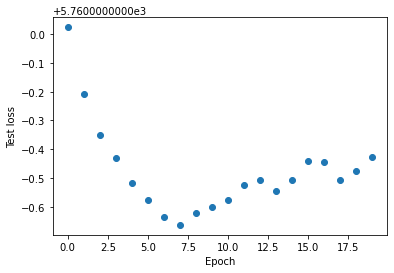

In [23]:
plt.scatter(range(epochs), array)
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.show()

In [24]:
#retrain less learning rate and longer
epochs = 50
rate = 0.00000001

loss = nn.L1Loss()
optim = torch.optim.Adam(params = model.parameters(), lr = rate)
array = np.zeros(epochs)

for epoch in range(epochs):
    train_step(model = model,
               data_loader = train_dataloader,
               loss_fn = loss,
               optim = optim)
    
    array[epoch] = test_step(model = model,
              data_loader = test_dataloader,
              loss_fn = loss, epoch = epoch)

test loss = 5759.550648082386 epoch is 0
test loss = 5759.599520596591 epoch is 1
test loss = 5759.448752663352 epoch is 2
test loss = 5759.548117897727 epoch is 3
test loss = 5759.510897549716 epoch is 4
test loss = 5759.592018821023 epoch is 5
test loss = 5759.568714488636 epoch is 6
test loss = 5759.605801669034 epoch is 7
test loss = 5759.493275035511 epoch is 8
test loss = 5759.516912286932 epoch is 9
test loss = 5759.498779296875 epoch is 10
test loss = 5759.528076171875 epoch is 11
test loss = 5759.559592507102 epoch is 12
test loss = 5759.598521839489 epoch is 13
test loss = 5759.486949573864 epoch is 14
test loss = 5759.560369318182 epoch is 15
test loss = 5759.523459694602 epoch is 16
test loss = 5759.554620916193 epoch is 17
test loss = 5759.50312943892 epoch is 18
test loss = 5759.569890802557 epoch is 19
test loss = 5759.480069247159 epoch is 20
test loss = 5759.491521661932 epoch is 21
test loss = 5759.631658380682 epoch is 22
test loss = 5759.551802201705 epoch is 23
tes

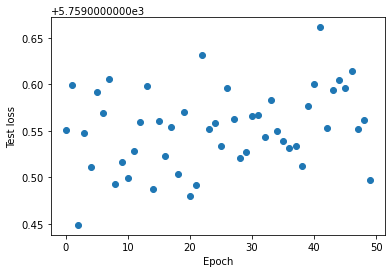

In [25]:
plt.scatter(range(epochs), array)
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.show()

In [26]:
torch.save(model.state_dict(), 'label_normal.pth')

We are now done with training our model. The below code is just for testing purposes

In [27]:
def price(car,
         trans,
         fuel,
         year,
         mile):
    em = model_key.loc[model_key['model'] == car]
    em = em.index[0]
    
    et = transmission_key.loc[transmission_key['transmission_type'] == trans]
    et = et.index[0]
    
    ef = fuel_key.loc[fuel_key['fuel_type'] == fuel]
    ef = ef.index[0]
    YM = scaler.transform(np.array((year, mile)).reshape(1, -1))
    year = YM[0, 0]
    print(year)
    mile = YM[0, 1]
    test = torch.tensor([year, mile, em, et, ef])
    return model(test.to(device).type(torch.float32)) * 0.88
    

def plotyear(car: str,
               trans: str,
               fuel: str,
               mile,
               year1 = 2005,
               year2 = 2023):
    em = model_key.loc[model_key['model'] == car]
    em = em.index[0]
    
    et = transmission_key.loc[transmission_key['transmission_type'] == trans]
    et = et.index[0]
    
    ef = fuel_key.loc[fuel_key['fuel_type'] == fuel]
    ef = ef.index[0]
    
    array = np.zeros(year2 - year1 + 1)
    
    for i in range(year1, year2 + 1):
        YM = scaler.transform(np.array((i, mile)).reshape(1,-1))
        i1 = YM[0, 0]
        mile = YM[0, 1]
        test = torch.tensor([i1, mile, em, et, ef])
        price = model(test.to(device).type(torch.float32)) * 0.88
        #print(i, price)
        array[i - year1] = price
    
    x = np.linspace(year1, year2, year2 - year1 + 1)
    plt.scatter(x, array)

In [28]:
#year1 = 2006
#year2 = 2023

carmodel = 'Ferrari 458'
cartrans = 'Automatic'
carfuel = 'Petrol'
caryear = 2013
#carpower =  100#bhp
#carpower *= 0.7457
carmile = 10 * 1000
price(carmodel, cartrans, carfuel, caryear, carmile)

0.6428571428571388


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


tensor(237626.5156, device='cuda:0', grad_fn=<MulBackward0>)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature nam

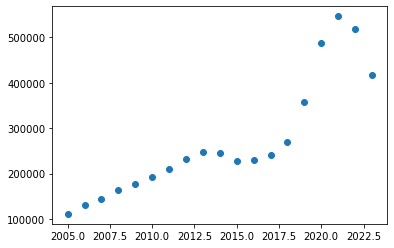

In [29]:
plotyear(carmodel, cartrans, carfuel, carmile)